In [ ]:
# Inspect the image (What are we trying to get from the image)
# Edge Detection (As we want the road lanes)
# Select the region of interest which is the road and discard other noises
# Draw line using HoughLinesP
# Draw co-ordinates with mean slope and intercept returned with array values of HoughLinesP
# Calculate the Average Slope Intercept to get the best fit for left and right lanes

In [1]:
#import packages
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [13]:
#reading in an image
img = cv2.imread("test_images/solidWhiteRight.jpg")
lane_image = np.copy(img)
print(lane_image)
rgb_img = cv2.cvtColor(lane_image,cv2.COLOR_BGR2RGB)

[[[212 196 179]
  [178 161 140]
  [180 156 132]
  ...
  [178 155 133]
  [180 159 144]
  [213 196 183]]

 [[180 161 140]
  [186 165 143]
  [185 161 133]
  ...
  [185 159 135]
  [181 159 141]
  [180 162 145]]

 [[180 157 131]
  [185 161 133]
  [187 160 126]
  ...
  [185 156 129]
  [184 158 134]
  [176 153 131]]

 ...

 [[126 121 120]
  [ 97  92  91]
  [ 89  84  83]
  ...
  [ 93  89  88]
  [ 99  95  94]
  [125 121 120]]

 [[143 139 138]
  [110 106 105]
  [ 95  90  89]
  ...
  [100  98  97]
  [112 110 109]
  [142 140 139]]

 [[185 181 180]
  [145 141 140]
  [123 118 117]
  ...
  [125 123 122]
  [143 141 140]
  [182 180 179]]]


In [3]:
def make_coordinates(image, line_parameters):

    slope, intercept = line_parameters
        
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    return np.array([x1,y1,x2,y2])

In [4]:
def average_slope_intercept(image,lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1,y1,x2,y2 = line.reshape(4)
        parameters = np.polyfit((x1,x2),(y1,y2),1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope<0:
            left_fit.append((slope,intercept))
        else:
            right_fit.append((slope,intercept))
    left_fit_average = np.average(left_fit,axis=0)
    right_fit_average = np.average(right_fit,axis=0)
    left_line = make_coordinates(image,left_fit_average)
    right_line = make_coordinates(image,right_fit_average)

    return np.array([left_line,right_line])

In [20]:
def canny_edge(image):
    # Converted the image into gray scale
    gray_img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # Applied Gaussian blur with the kernel size of (5,5) to overall noise as we only want the structure of the images (Not interested in details)
    blur = cv2.GaussianBlur(gray_img,(5,5),0)
    # Applied Canny Edge detection passing the blurred image as as source (Lower and upper threshold) if pixel < lower not an edge 
    # if pixel > upper is an edge. if in between it needs to process further comparing with the strong edge if strong edge then consider
    # else not
    canny = cv2.Canny(blur,50,150)
    return canny

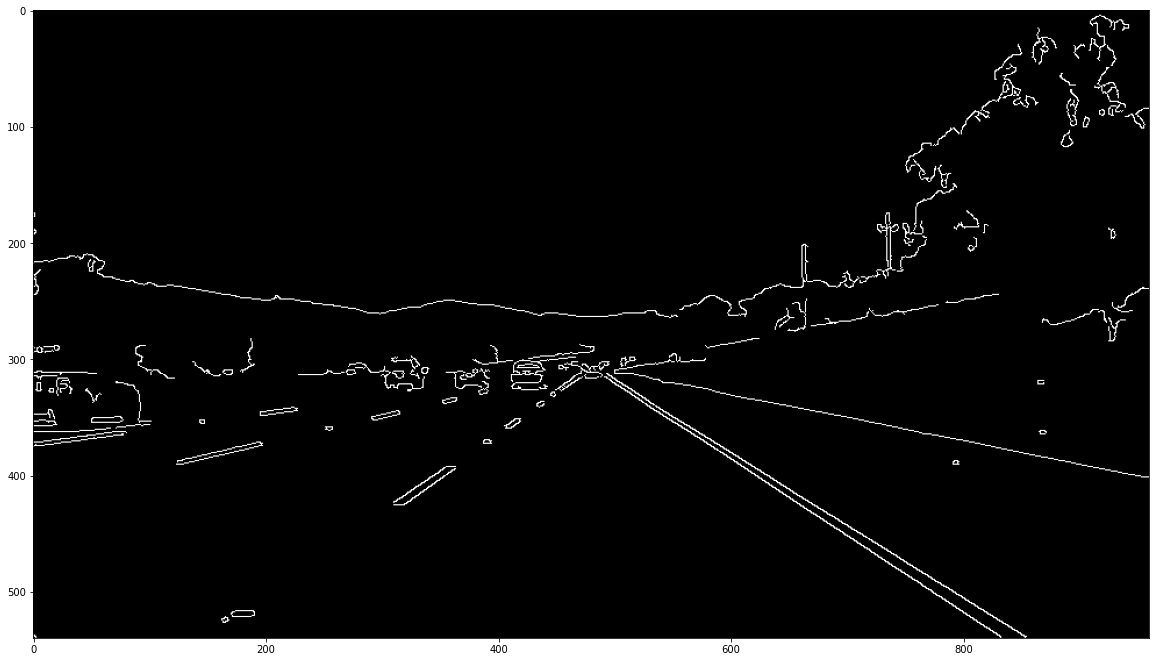

In [41]:
canny = canny_edge(lane_image)
plt.figure(figsize=(20,15))
plt.imshow(canny, cmap='gray')

In [7]:
def display_lines(image,lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1,y1,x2,y2 = line.reshape(4)
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
    return line_image
        

In [39]:
def region_of_interest(image):
    # Our region of interest is based on the height and width of the image. 
    height = image.shape[0]
    width = image.shape[1]
    #channels = image.shape[2]
    roi_points = np.array([[(0, height), (width/2, height/2), (width, height)]]).astype('int32')
    # Returns the same shape of the image with zeroes
    mask = np.zeros_like(image)
    # Fill the areas bounded by the polygon points (Mask with whites)
    cv2.fillPoly(mask, roi_points, 255)
    # AND: A bitwise AND is true if and only if both pixels are greater than zero.
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

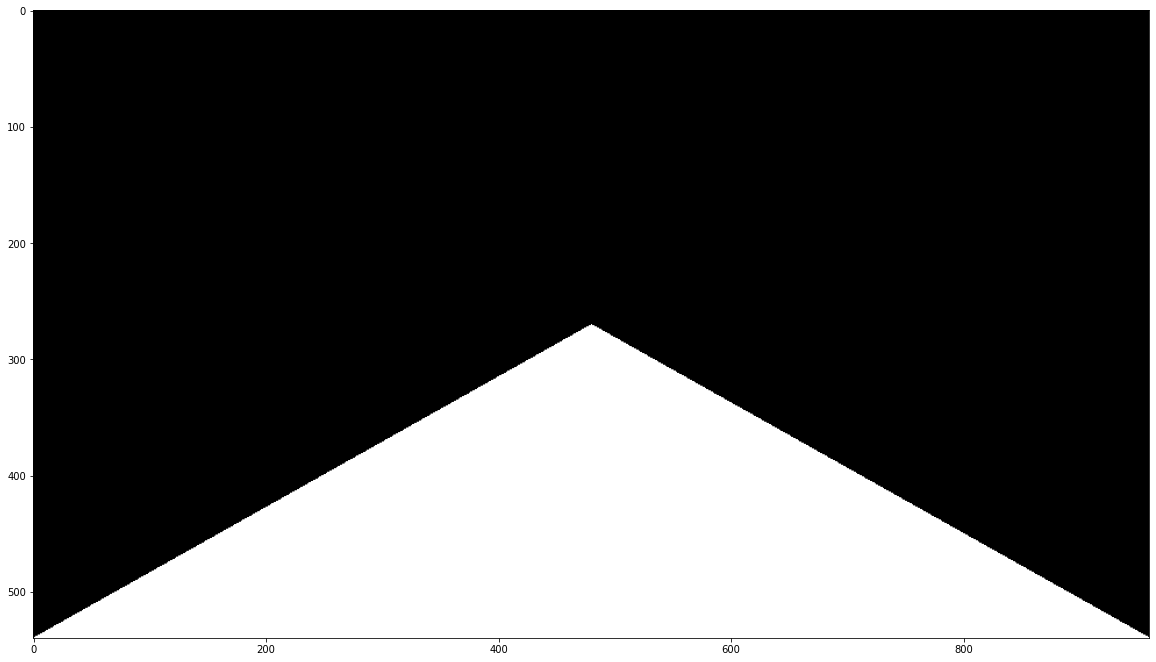

In [34]:
# Displaying Region of Interest (mask)
plt.figure(figsize=(20,15))
plt.imshow(region_of_interest(canny), cmap='gray')

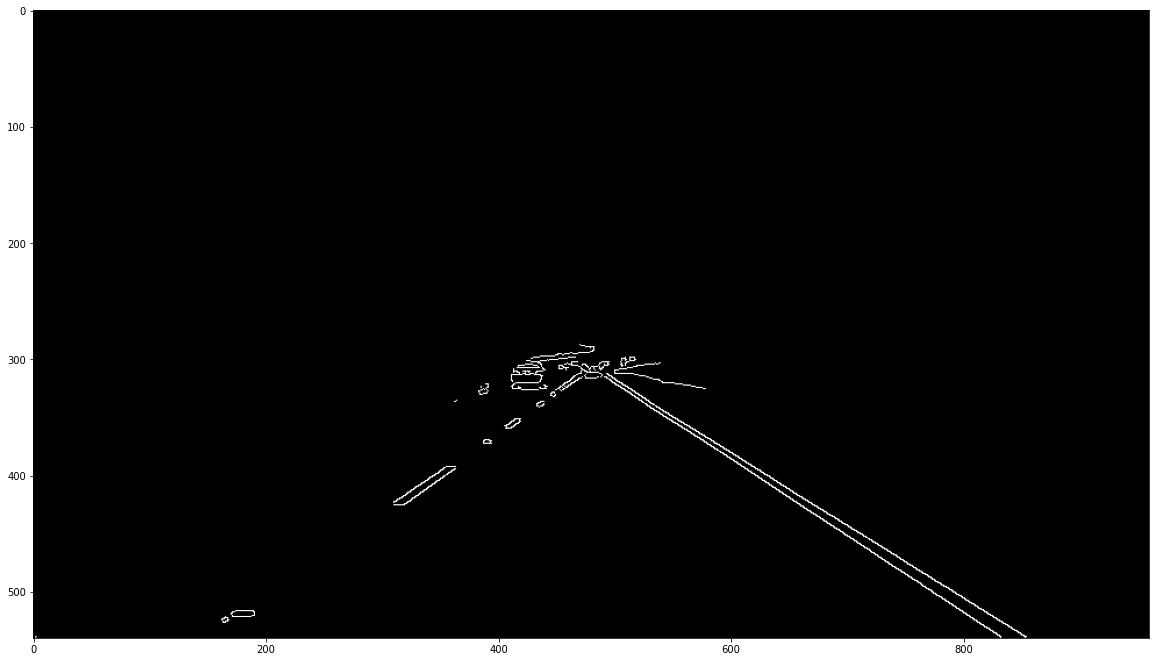

In [40]:
plt.figure(figsize=(20,15))
plt.imshow(region_of_interest(canny), cmap='gray')

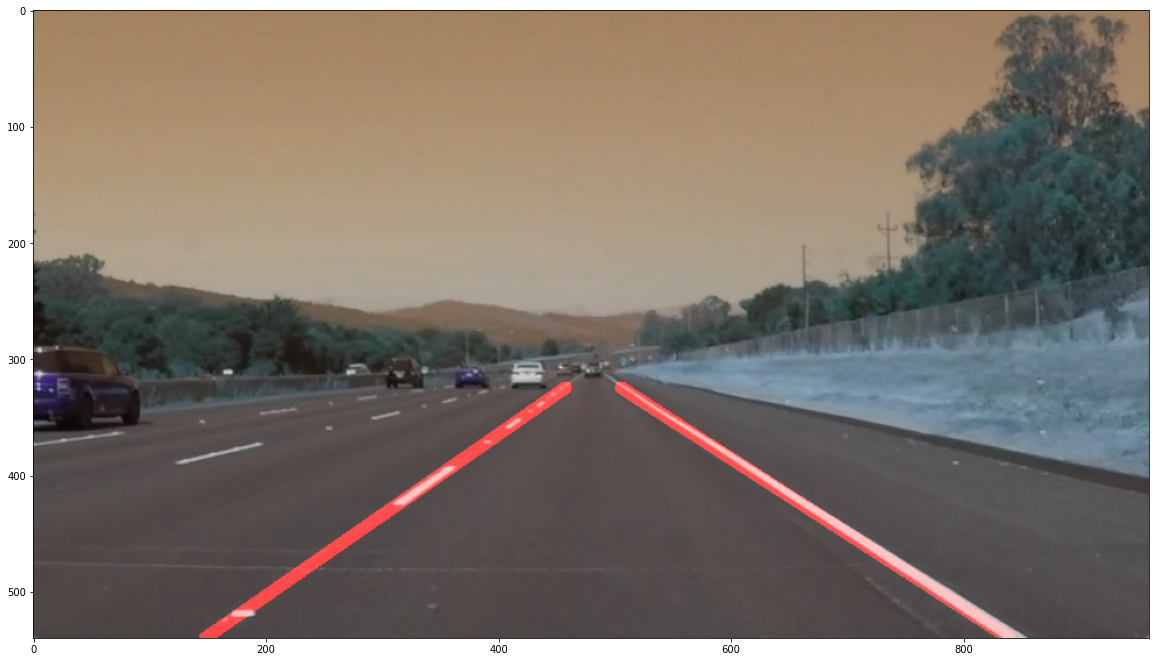

In [31]:
cannys = region_of_interest(canny)
lines = cv2.HoughLinesP(cannys,2,np.pi/180,100,np.array([]), minLineLength = 40, maxLineGap = 25)
averaged_lines = average_slope_intercept(lane_image,lines)
line_image = display_lines(lane_image,averaged_lines)
combo_image = cv2.addWeighted(lane_image,0.8,line_image,1,1)

plt.figure(figsize=(20,15))
plt.imshow(combo_image)

In [44]:
cap = cv2.VideoCapture("test_videos/solidYellowLeft.mp4")
while(cap.isOpened()):
    ret,frame = cap.read()
    my_canny = cv2.Canny(frame,100,150)
    cannys = region_of_interest(my_canny)
    lines = cv2.HoughLinesP(cannys,2,np.pi/180,100,np.array([]),minLineLength = 40, maxLineGap = 25)
    averaged_lines = average_slope_intercept(frame, lines)
    line_image = display_lines(frame, averaged_lines)
    combo_image = cv2.addWeighted(frame,0.8,line_image,1,1)
    cv2.imshow("image",combo_image)
    if cv2.waitKey(25) & 0xFF == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()